# PDS Search API demo, OSIRIS-REx OVIRS Data Visualization
## PART 1: Explore a Collection

The purpose of this notebook is to demostrate how the PDS web API can be used to access the PDS data for a scientific use case.

The documention of the PDS web API is available on https://nasa-pds.github.io/pds-api/

This notebook is available on https://github.com/NASA-PDS/pds-api-notebook

<b>2 Use cases:</b>
 - <u>Part1</u>: explore the collection
 - <u>Part2</u>: find/visualize specific the data you are interested in
 
 <br/>
 
 WARNING: This notebook is a demo and not a real scientific use case. It might contain mistake in the way the data is used or displayed.

In [9]:
from __future__ import print_function
from pprint import pprint
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

The PDS API is accessed using a python client library documented on https://nasa-pds.github.io/pds-api-client/

In [10]:
import pds.api_client as pds_api

## Use the PDS demo web API server 

Connect to the demo server. See User Interface of the web API: https://pds-gamma.jpl.nasa.gov/api/swagger-ui.html

<b>Note: </b> this piece of code will be wrapped into a helper function so that 1 line will be enough to connect to the API using a default host

In [11]:
configuration = pds_api.Configuration()

# demo server
configuration.host = 'https://pds.nasa.gov/api/search/1.0'

api_client = pds_api.ApiClient(configuration)


## Explore a collection

### Get the lidvid of your collection of interest

Search for a collection of interest on https://pds.nasa.gov/datasearch/keyword-search/ (or https://pds.nasa.gov > Data Search > Keyword Search):
- Search for "osiris rex calibrated ovirs collection" (https://pds.nasa.gov/datasearch/keyword-search/search.jsp?q=osiris+rex+ovirs+calibrated+collection)
- Click on the first collection on the results
- Copy the lidvid


### Get the properties available for the observational products belonging to the selected collection

<font color='red'>Currently the operation does not work on the server deployed in production, see https://github.com/NASA-PDS/registry-api/issues/152</font>

Get the properties available for the product belonging to the collection of interest using `CollectionsProductsApi.products_of_a_collection` 
(see https://nasa-pds.github.io/pds-api-client/api/api_client.api.html#api_client.api.collections_products_api.CollectionsProductsApi)

API responses have the structure `{"summary": {}, data= []}`
(see https://nasa-pds.github.io/pds-api-client/api/api_client.models.html#api_client.models.products.Products)

We do not get the product descriptions yet but only the available properties with `only_summary=True` option.

In [22]:
lidvid = 'urn:nasa:pds:orex.ovirs:data_calibrated'

from pds.api_client.api.collections_products_api import CollectionsProductsApi
collection_products_api = CollectionsProductsApi(api_client)
api_response = collection_products_api.products_of_a_collection(
    lidvid,  
    start=0, 
    limit=200, 
    #summary_only=True
)

print(f"The available properties for the selected products are {api_response.summary.properties}")

The available properties for the selected products are []


### Request specific properties of all the observational products of the collection

Properties have a syntax alike the PDS4 model: class/attributes. 

Get the latitude, longitude and target_range of the observational products belonging to the collection, with `fields=` option.

The API results are <b>paginated</b>, to get all the results we need to loop through the pages.

In [37]:
properties_of_interest = ['orex:Spatial.orex:latitude', 'orex:Spatial.orex:longitude', 'orex:Spatial.orex:target_range']
from pds.api_client.exceptions import NotFoundException

start = 0
limit = 500
products = []
pbar = tqdm()

start_time = time.time()
while True:
    try:
        pbar.update(int(start/500))

        api_response = collection_products_api.products_of_a_collection(
            lidvid, 
            start=start, 
            limit=limit, 
            fields=properties_of_interest)
        
        products.extend(api_response.data)
        start += limit
        
    except NotFoundException as e:
        print("All pages retrieved")
        break

elapsed = time.time() - start_time
print(f'retrieved {start} products in {elapsed/60.0:.1f} minutes')

pbar.close()



0it [00:00, ?it/s]

All pages retrieved
retrieved 151000 products in 37.9 minutes


In [38]:
api_response.summary

{'hits': 150872,
 'limit': 500,
 'properties': [],
 'q': '',
 'sort': [],
 'start': 150500,
 'took': 4953}

### Product description comes with default properties + requested properties

See for example

In [39]:
products[140000]

{'id': 'urn:nasa:pds:orex.ovirs:data_calibrated:20191120t091020s246_ovr_scil2_calv2.fits::1.0',
 'investigations': [{'href': 'http://pds.nasa.gov/products/urn:nasa:pds:context:investigation:mission.orex',
                     'id': 'urn:nasa:pds:context:investigation:mission.orex'}],
 'metadata': {'creation_date_time': '2020-08-02T21:31:16.753Z',
              'label_url': '/dsk1/www/archive/pds4/orex/orex.ovirs/data_calibrated/orbit_r/20191120T091020S246_ovr_scil2_calv2.xml',
              'update_date_time': '2019-02-01T00:00:00Z',
              'version': '1.0'},
 'observing_system_components': [{'href': 'http://pds.nasa.gov/products/urn:nasa:pds:context:instrument_host:spacecraft.orex',
                                  'id': 'urn:nasa:pds:context:instrument_host:spacecraft.orex'},
                                 {'href': 'http://pds.nasa.gov/products/urn:nasa:pds:context:instrument:ovirs.orex',
                                  'id': 'urn:nasa:pds:context:instrument:ovirs.orex'}]

### Filter out records with no valid values

Some records have fill values for the fields we are interested in (e.g. `latitude == -9999`, we want to remove them from our results.


In [65]:
def at_least_one_valid_value(p):
    return ((p['orex:Spatial.orex:latitude']['value'][0] !=  '-9999') \
           and (p['orex:Spatial.orex:latitude']['value'][0] != None))

def filter_out_fillvalues(products):
    properties = []
    for product in products:
        if at_least_one_valid_value(product.properties):
            p = product.properties
            p['id'] = product.id
            properties.append(p)
    return properties

properties = filter_out_fillvalues(products)
        
print(f"The values of the selected properties are")
pprint(properties[:3])

The values of the selected properties are
[{'id': 'urn:nasa:pds:orex.ovirs:data_calibrated:20191125t050139s014_ovr_scil2_calv2.fits::1.0',
  'lidvid': ['urn:nasa:pds:orex.ovirs:data_calibrated:20191125t050139s014_ovr_scil2_calv2.fits::1.0'],
  'ops:Label_File_Info.ops:file_ref': ['/dsk1/www/archive/pds4/orex/orex.ovirs/data_calibrated/orbit_r/20191125T050139S014_ovr_scil2_calv2.xml'],
  'ops:Tracking_Meta.ops:archive_status': ['archived'],
  'orex:Spatial.orex:latitude': ['-35.759272770084'],
  'orex:Spatial.orex:longitude': ['13.6467665478551'],
  'orex:Spatial.orex:target_range': ['1.1641864906570298'],
  'pds:File.pds:creation_date_time': ['2020-08-02T23:42:23.977Z'],
  'pds:Modification_Detail.pds:modification_date': ['2019-02-01T00:00:00Z'],
  'pds:Time_Coordinates.pds:start_date_time': ['2019-11-25T05:01:39.014Z'],
  'pds:Time_Coordinates.pds:stop_date_time': ['2019-11-25T05:01:39.014Z'],
  'product_class': ['Product_Observational'],
  'ref_lid_instrument': ['urn:nasa:pds:context

### Transpose to extract lat,lon and target range as columns, ready to plot 

In [66]:
def transpose(properties):
    lat = [float(p['orex:Spatial.orex:latitude']['value'][0]) for p in properties]
    lon = [float(p['orex:Spatial.orex:longitude']['value'][0]) for p in properties]
    target_range = [float(p['orex:Spatial.orex:target_range']['value'][0]) for p in properties]
    return lat, lon, target_range

lat, lon, target_range = transpose(properties)
print(f'The target_range values for the selected products are {target_range[:3]}')

The target_range values for the selected products are [1.1641864906570298, 1.1640928314889798, 1.1632493524312]


### Plot the lat,lon of the observations, colored by target_range

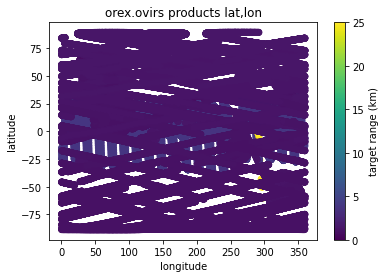

In [67]:
def observation_map(lat, lon, target_range, vmax=25):
    fig, ax = plt.subplots()

    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude')
    ax.set_title('orex.ovirs products lat,lon')

    im = ax.scatter(lon, lat, c=target_range, vmin=0, vmax=vmax)

    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('target range (km)')
    
observation_map(lat,lon, target_range, vmax=25)


### Overview of the observation target_range with an histogram

(array([122460.,   2789.,  10310.,   3157.,   2298.,    576.,      0.,
             0.,      0.,      0.]),
 array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ]),
 <BarContainer object of 10 artists>)

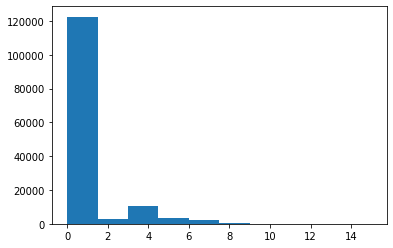

In [52]:
plt.hist(target_range, range=(0, 15))

### Get observations around specific spot (lat=12, lon=24) with target range closer than 4 km

In [55]:
lidvids = [p['id'] for p in properties if float(p['orex:Spatial.orex:target_range']['value'][0]) < 4.0 
          and abs(float(p['orex:Spatial.orex:latitude']['value'][0]) - 12.0) < 3.0
          and abs(float(p['orex:Spatial.orex:longitude']['value'][0]) - 24.0) < 3.0]
print(f'The lidvids of the selected products are {lidvids}')

The lidvids of the selected products are ['urn:nasa:pds:orex.ovirs:data_calibrated:20190926t202037s675_ovr_scil2_calv2.fits::1.0', 'urn:nasa:pds:orex.ovirs:data_calibrated:20190926t202039s575_ovr_scil2_calv2.fits::1.0', 'urn:nasa:pds:orex.ovirs:data_calibrated:20190926t202041s375_ovr_scil2_calv2.fits::1.0']


### Get the full product description

In [57]:
from pds.api_client.api.products_api import ProductsApi
products_api = ProductsApi(api_client)
product = products_api.products_by_lidvid(lidvids[0])
print(product)

{'id': 'urn:nasa:pds:orex.ovirs:data_calibrated:20190926t202037s675_ovr_scil2_calv2.fits::1.0',
 'investigations': [{'href': 'http://pds.nasa.gov/products/urn:nasa:pds:context:investigation:mission.orex',
                     'id': 'urn:nasa:pds:context:investigation:mission.orex'}],
 'metadata': {'creation_date_time': '2020-08-02T17:49:08.183Z',
              'label_url': '/dsk1/www/archive/pds4/orex/orex.ovirs/data_calibrated/recon/20190926T202037S675_ovr_scil2_calv2.xml',
              'update_date_time': '2019-02-01T00:00:00Z',
              'version': '1.0'},
 'observing_system_components': [{'href': 'http://pds.nasa.gov/products/urn:nasa:pds:context:instrument_host:spacecraft.orex',
                                  'id': 'urn:nasa:pds:context:instrument_host:spacecraft.orex'},
                                 {'href': 'http://pds.nasa.gov/products/urn:nasa:pds:context:instrument:ovirs.orex',
                                  'id': 'urn:nasa:pds:context:instrument:ovirs.orex'}],


### Get the file path of the data

In [58]:
product.properties['ops:Data_File_Info.ops:file_ref']

['/dsk1/www/archive/pds4/orex/orex.ovirs/data_calibrated/recon/20190926T202037S675_ovr_scil2_calv2.fits']